**Author**: Yap Jheng Khin

**FYP II Title**: Used car dealership web application

**Purpose**:
- This notebook analyzes the performance of ARF and TRF regression models with and without the influence of data drift or concept drift.
- Input: 
    - TRF model
    - Pre-trained ARF model in which its weights are transfered from the TRF model 
- Ouput
    - Performance analysis results
    - Pre-trained ARF model that is trained with drifted data
    - ARF model that is trained from scratch 

**Technical jargon**
1. ARF - Adaptive random forest
2. TRF - Traditional random forest

**Execution time**: At most 10 minutes in Jupyter Notebook.

# Setup

Ensure that the current Python interpreter path is correct. For example, if the **River conda environment** is named as **arf_conda_env**, the expected `sys.executable` should be C:\Users\User\miniconda3\envs\\**arf_conda_env**\\python.exe.

In [ ]:
import sys
print(sys.executable)

## Import

Import libraries.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

# User libraries
from arf_training import train_arf_rg
from rf_rg_performance_eval import get_running_metrics, measure_performance, plot_performance_graph, arf_predict, analyze_trees

Initialise constants and seed for reproducibility.

In [2]:
#Intialise a random number generator
# Source: https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
RANDOM_SEED = 2022
RANDOM_NUMBER_GENERATOR = np.random.default_rng(RANDOM_SEED)
DECIMAL_POINTS = 3

OUT_PARENT_DIR = 'outputs'
OUT_CHILD_DIR = 'rg_transfer_learning'
OUT_FOLDER_PATH = os.path.join(OUT_PARENT_DIR, OUT_CHILD_DIR) 

# Create directory if not exist
os.makedirs(OUT_FOLDER_PATH, exist_ok=True)

##  Data Setup

No concept drift stream generators are used since none of the generated stream can train well with the traditional random forest regressor. Instead, the California housing dataset is used since the traditional random forest can be trained well with it. The TRF is trained with this dataset before its training weights are transferred to the ARF. The target is the median house price and the drift is manually induced by increasing the price by 25% due to economic factors like inflation or war.

Load the data used in `FYP2_ARF_RF_Transfer_Learning.ipynb` for consistency.

1. The first 20,640 samples were **offline** data initially used in training algorithms. This data was used to test models' performance without concept drift. 
2. The last 20,640 samples were **online** data that experience concept drift over time. This data was used to test models' performance under concept drift. 
3. 4,128 samples out of 20,640 samples would be used to check model's generalisation error.

In [3]:
train_set = pd.read_csv(os.path.join(OUT_FOLDER_PATH, 'cal_housing_train_set.csv'))
test_set = pd.read_csv(os.path.join(OUT_FOLDER_PATH, 'cal_housing_test_set.csv'))

y_attr = 'MedHouseVal'

X_train = train_set.drop(columns=y_attr, axis=1)
y_train = train_set[y_attr]

X_test = test_set.drop(columns=y_attr, axis=1)
y_test = test_set[y_attr]

num_attrs = X_train.columns
cat_attrs = []

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (16512, 8)
y_train shape (16512,)
X_test shape (4128, 8)
y_test shape (4128,)


## Model Setup

Import the trained TRF model and the ARF model. Note that the ARF model get its weights from the offline-trained TRF model instead of incrementally trained with the offline data.

In [4]:
# Load data preprocessor
with open(os.path.join(OUT_FOLDER_PATH, 'data_preprocessor.pkl'), 'rb') as f:
    data_pp = pickle.load(f)

# Load random forest
with open(os.path.join(OUT_FOLDER_PATH, 'trf_randf_rg_trained.pkl'), 'rb') as f:
    trf_rg = pickle.load(f)

# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_rg_weight_transferred.pkl'), 'rb') as f:
    arf_rg = pickle.load(f)

# Performance without drift

This section is about evaluating the model performance in offline settings. The TRF is trained with 16,512 samples of offline train data. Then, the weights of TRF is transfered to the ARF. The train performance and generalized performance of ARF and TRF is evaluated using the next 4,128 samples of offline test data. The purpose of this section is to prove that the <u>offline performance of adaptive random forest regressor is as good as or better than traditional random forest regressor</u>.

The transfer learning algorithm is demonstrated at *FYP2_ARF_RG_Transfer_Learning.ipynb*. 

In [5]:
cat_attrs = ['x3', 'x7', 'x8']
num_attrs = ['x1', 'x2', 'x4', 'x5', 'x6', 'x9', 'x10']

`rg_pred_res` is a dictionary that stores models, predictions and metrics for four different subsets of data.

The four subset of data are:
- Train data without drift.
- Test data without drift.
- Train data with drift.
- Test data with drift.

In [6]:
MODEL_TYPES = ['TRF', 'ARF_pretrained', 'ARF_fr_scratch']
rg_pred_res = {}
# First level
CONDITIONS = ['normal', 'drift']
# Second level
DATA_TYPES = ['train', 'test']
# Third level
RECORD_TYPES = ['model', 'pred', 'residual', 'mse', 'mae', 'r2', 'label']

# Initialise rg_pred_res
for condition in CONDITIONS:
    rg_pred_res[condition] = {}
    for data_type in DATA_TYPES:
        rg_pred_res[condition][data_type] = {}
        for record_type in RECORD_TYPES:
            rg_pred_res[condition][data_type][record_type] = {}
            
rg_pred_res

{'normal': {'train': {'model': {},
   'pred': {},
   'residual': {},
   'mse': {},
   'mae': {},
   'r2': {},
   'label': {}},
  'test': {'model': {},
   'pred': {},
   'residual': {},
   'mse': {},
   'mae': {},
   'r2': {},
   'label': {}}},
 'drift': {'train': {'model': {},
   'pred': {},
   'residual': {},
   'mse': {},
   'mae': {},
   'r2': {},
   'label': {}},
  'test': {'model': {},
   'pred': {},
   'residual': {},
   'mse': {},
   'mae': {},
   'r2': {},
   'label': {}}}}

## Train adaptive random forest

Before measuring the performance, a new ARF is trained from scratch to serve as a baseline performance for pre-trained ARF.

In [7]:
# Load and initialise a new adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_rg_weight_transferred.pkl'), 'rb') as f:
    arf_rg_tmp = pickle.load(f)

# Note that the model is brand new as indicated by the emtpy data attribute
new_arf_rg = arf_rg_tmp.clone()
new_arf_rg.__dict__

X_train_pp = data_pp.preprocess(X_train)

# Train the model using the offline data
new_arf_rg, runninng_metrics_new_arf_train = train_arf_rg(new_arf_rg, X_train_pp, y_train)

Training adaptive random forest algorithm: 100%|████████████████████| 16512/16512 [04:44<00:00, 58.12it/s]


Below shows the number of nodes and height of each base learners in the respective models. The number of nodes and maximum height in **TRF** and **ARF_fr_scratch** are all the same since the training weights are directly transferred from one to another.

In [8]:
models = {
    'TRF': trf_rg,
    'ARF_fr_scratch': new_arf_rg,
    'ARF_pretrained': arf_rg
}

analyze_trees(models)

1     2     3     4     5     6     7     8   \
Model          Properties                                                    
TRF            total_nodes   829   873   839   777   739   873   791   863   
               max_height     15    15    15    15    15    15    15    15   
ARF_fr_scratch total_nodes  2093  2137  2055  2171  2083  2115  2027  2097   
               max_height     23    23    23    22    22    24    22    24   
ARF_pretrained total_nodes   829   873   839   777   739   873   791   863   
               max_height     15    15    15    15    15    15    15    15   

                              9     10    11    12    13    14    15  
Model          Properties                                             
TRF            total_nodes   819   809   829   867   841   787   843  
               max_height     15    15    15    15    15    15    15  
ARF_fr_scratch total_nodes  2095  2141  2063  2059  2085  2091  2127  
               max_height     19    22    27    19    23    20    25  
ARF_pretrained total_nodes   819   809   829   867   841   787   843  
               max_height     15    15    15    15    15    15    15


Total nodes:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,829,873,839,777,739,873,791,863,819,809,829,867,841,787,843
ARF_fr_scratch,2093,2137,2055,2171,2083,2115,2027,2097,2095,2141,2063,2059,2085,2091,2127
ARF_pretrained,829,873,839,777,739,873,791,863,819,809,829,867,841,787,843



Maximum height:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
ARF_fr_scratch,23,23,23,22,22,24,22,24,19,22,27,19,23,20,25
ARF_pretrained,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


## Train performance

The output compares the training performance between TRF and ARF in the offline setting. It can be inferred that the transfer learning process is **successful** as the R-squared value of both **TRF** and **pretrained ARF** differs no more than 1%. There is a slight difference in the performance since the leaf prediction mechanisms in the **TRF** and **ARF** are different. 


On the other hand, the training performance of **ARF that is trained from scratch** is slightly lower than **pretrained ARF** with the R-squared value difference of 1%. 

Performing predictions: 100%|█████████████████████████████████████| 16512/16512 [00:14<00:00, 1102.02it/s]


,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
mse,0.2153,0.2282,0.2455,-0.0129,-0.0302,-0.0173
mae,0.3247,0.3255,0.3483,-0.0008,-0.0236,-0.0228
r2,0.8394,0.8298,0.8169,0.0096,0.0225,0.0129


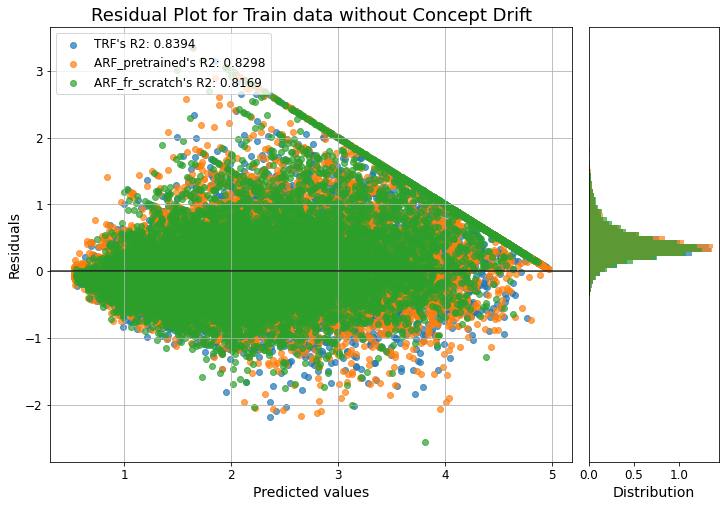

In [9]:
rg_pred_res['normal']['train']['model']['TRF'] = trf_rg
rg_pred_res['normal']['train']['model']['ARF_pretrained'] = arf_rg
rg_pred_res['normal']['train']['model']['ARF_fr_scratch'] = new_arf_rg

params = {
    'pred_records': rg_pred_res['normal']['train'],
    'X': X_train,
    'y': y_train,
    'data_pp': data_pp,
    'binwidth': 0.1,
    'plot_title': 'Residual Plot for Train data without Concept Drift'
}

measure_performance(**params)

## Test performance

The output compares the generalization performance between TRF and ARF in the offline setting. The output again proves that transfer learning process is **successful** as the ROC AUC score of both **TRF** and **pretrained ARF** differs no more than 1%. 

On the other hand, the generalization performance of **ARF that is trained from scratch** is the lowest with a ROC AUC score difference of 5% as compared to **pretrained ARF**. However, the result cannot guarantee the superiority of the **transfer learning algorithm** for other datasets. For further details, please refer to *FYP2_Car_Price_Model_Training.ipynb*. Summarizing from the file, the initial performance boost provided by transfer learning varies from one dataset to another.

It can be observed that all the models suffer from overfitting. In business scenarios, TRF and ARF should undergo thorough hyperparameter tunning to further reduce overfitting. 

Performing predictions: 100%|████████████████████████████████████████| 4128/4128 [00:04<00:00, 944.34it/s]


,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
mse,0.2953,0.2945,0.3560,0.0008,-0.0607,-0.0615
mae,0.3771,0.3698,0.4170,0.0073,-0.0399,-0.0472
r2,0.7718,0.7724,0.7249,-0.0006,0.0469,0.0475


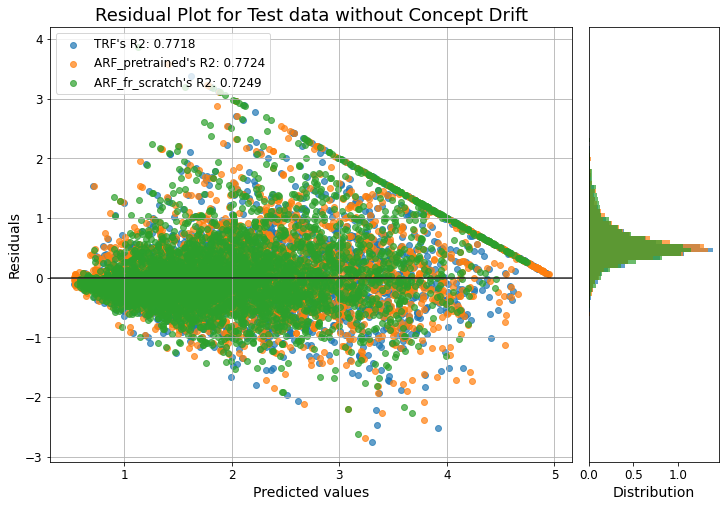

In [10]:
rg_pred_res['normal']['test']['model']['TRF'] = trf_rg
rg_pred_res['normal']['test']['model']['ARF_pretrained'] = arf_rg
rg_pred_res['normal']['test']['model']['ARF_fr_scratch'] = new_arf_rg

params = {
    'pred_records': rg_pred_res['normal']['test'],
    'X': X_test,
    'y': y_test,
    'data_pp': data_pp,
    'binwidth': 0.1,
    'plot_title': 'Residual Plot for Test data without Concept Drift'
}

measure_performance(**params)

# Performance with drift

This section is about evaluating the model performance in online settings where drifted data is frequently encountered. The ARF (*online model*) is incrementally trained and evaluated with the 16,512 samples of drifted train data, while the TRF (*offline model*) is only evaluated using the same drifted train data. Finally, the generalized performance of ARF and TRF are evaluated using the last 4,128 samples of drifted test data. The purpose of this section is to prove that the <u>online performance of adaptive random forest regressor is better than traditional random forest regressor</u>.

## Data Setup

Due to the absence of drift generator, the dataset must be manually shifted. let's assume that the median house price has gone up by 25% due to economic inflation or war.

In [11]:
INFLATION_RATE = 1.25

# Simulate gradual concept drift
def inflate_house_price(y):
    inflation_rates = np.linspace(1, INFLATION_RATE, num=5)
    num_steps = len(inflation_rates)
    step_size = round(len(y) / num_steps)

    for idx, inflation_rate in enumerate(inflation_rates):
        start_idx = idx * step_size
        end_idx = (idx+1) * step_size
        y[start_idx:end_idx] *= inflation_rate

    return y

In [12]:
X_train_drifted = train_set.drop(columns=y_attr, axis=1)
# y_train_drifted = inflate_house_price(y_train.copy())
y_train_drifted = y_train * INFLATION_RATE

X_test_drifted = test_set.drop(columns=y_attr, axis=1)
y_test_drifted = y_test * INFLATION_RATE

print(f'X_train shape {X_train_drifted.shape}')
print(f'y_train shape {y_train_drifted.shape}')
print(f'X_test shape {X_test_drifted.shape}')
print(f'y_test shape {y_test_drifted.shape}')

X_train shape (16512, 8)
y_train shape (16512,)
X_test shape (4128, 8)
y_test shape (4128,)


## Train adaptive random forest

Incrementally train and evaluate both the adaptive random forest models.

In [13]:
# Preprocess data
X_train_drifted_pp = data_pp.preprocess(X_train_drifted)

trained_arf_rg_fr_scratch, runninng_metrics_new_arf_train_drifted = \
train_arf_rg(new_arf_rg, X_train_drifted_pp, y_train_drifted)

# Save the adaptive random forest that is trained from scratch
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_rg_trained_from_scratch.pkl'), 'wb') as f:
    pickle.dump(trained_arf_rg_fr_scratch, f)

Training adaptive random forest algorithm: 100%|████████████████████| 16512/16512 [04:52<00:00, 56.39it/s]


In [14]:
trained_arf_rg, runninng_metrics_arf_train_drifted = train_arf_rg(arf_rg, X_train_drifted_pp, y_train_drifted)

# Save the pre-trained adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_rg_trained.pkl'), 'wb') as f:
    pickle.dump(trained_arf_rg, f)

Training adaptive random forest algorithm: 100%|████████████████████| 16512/16512 [04:21<00:00, 63.23it/s]


Below shows the number of nodes and height of each base learners in the respective models. 

In [15]:
models = {
    'TRF': trf_rg,
    'ARF_fr_scratch': trained_arf_rg_fr_scratch,
    'ARF_pretrained': trained_arf_rg
}

analyze_trees(models)

1     2     3     4     5     6     7     8   \
Model          Properties                                                    
TRF            total_nodes   829   873   839   777   739   873   791   863   
               max_height     15    15    15    15    15    15    15    15   
ARF_fr_scratch total_nodes  1975  2025  2091  2023  2047  2073  2055  2047   
               max_height     27    25    23    23    22    22    23    23   
ARF_pretrained total_nodes  1689  1831  1857  1821  1649  1713  1619  1655   
               max_height     20    21    21    23    19    21    20    18   

                              9     10    11    12    13    14    15  
Model          Properties                                             
TRF            total_nodes   819   809   829   867   841   787   843  
               max_height     15    15    15    15    15    15    15  
ARF_fr_scratch total_nodes  2103  2053  2067  2049  2037  2043  2009  
               max_height     23    20    20    23    22    21    20  
ARF_pretrained total_nodes  1553  1621  1625  1573  1677  1673  1801  
               max_height     24    19    21    19    21    20    20


Total nodes:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,829,873,839,777,739,873,791,863,819,809,829,867,841,787,843
ARF_fr_scratch,1975,2025,2091,2023,2047,2073,2055,2047,2103,2053,2067,2049,2037,2043,2009
ARF_pretrained,1689,1831,1857,1821,1649,1713,1619,1655,1553,1621,1625,1573,1677,1673,1801



Maximum height:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
ARF_fr_scratch,27,25,23,23,22,22,23,23,23,20,20,23,22,21,20
ARF_pretrained,20,21,21,23,19,21,20,18,24,19,21,19,21,20,20


## Train performance

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Offline Train R2</th>
        <th style="text-align:left;">Online Train R2</th>
        <th style="text-align:left;">Difference</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.8394</td>
        <td style="text-align:center;">0.6493</td>
        <td style="text-align:center;">-0.1901</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.8298</td>
        <td style="text-align:center;">0.7950</td>
        <td style="text-align:center;">-0.0348</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.8169</td>
        <td style="text-align:center;">0.8042</td>
        <td style="text-align:center;">-0.0127</td>
    </tr>
</table>

The output compares the training performance between TRF and ARF in the online setting. Due to drift, all of the models' performance are affected. The train performance of **TRF** has the most impact with a drop of 19% followed by both performance of ARF with a drop of at most 4%. It can be deduced that ARF algorithm is more robust against drift as compared to TRF algorithm. 


On the other hand, the training performance of **pre-trained ARF** is similar to **ARF that is trained from scratch** with a slight R-squared value difference of 1%. 

Performing predictions: 100%|█████████████████████████████████████| 16512/16512 [00:14<00:00, 1149.79it/s]


,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
mse,0.7346,0.4294,0.4101,0.3052,0.3245,0.0193
mae,0.6012,0.4631,0.4540,0.1381,0.1472,0.0091
r2,0.6493,0.7950,0.8042,-0.1457,-0.1549,-0.0092


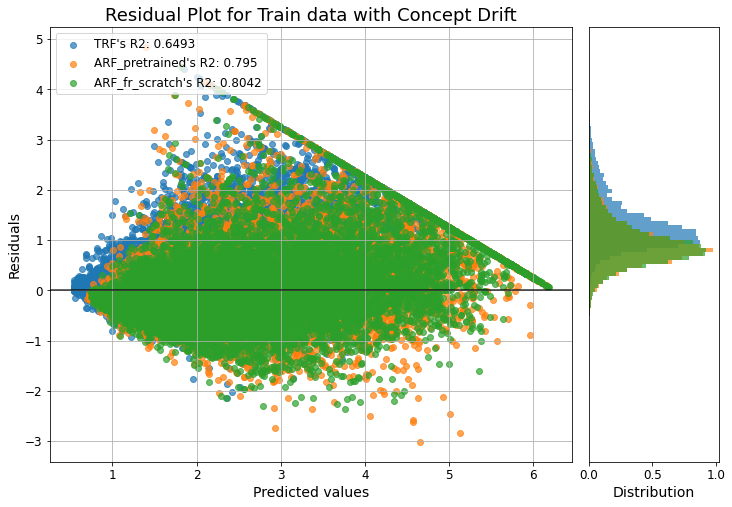

In [16]:
rg_pred_res['drift']['train']['model']['TRF'] = trf_rg
rg_pred_res['drift']['train']['model']['ARF_pretrained'] = trained_arf_rg
rg_pred_res['drift']['train']['model']['ARF_fr_scratch'] = trained_arf_rg_fr_scratch

params = {
    'pred_records': rg_pred_res['drift']['train'],
    'X': X_train_drifted,
    'y': y_train_drifted,
    'data_pp': data_pp,
    'binwidth': 0.1,
    'plot_title': 'Residual Plot for Train data with Concept Drift'
}

measure_performance(**params)

## Test performance

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Offline Test R2</th>
        <th style="text-align:left;">Online Test R2</th>
        <th style="text-align:left;">Difference</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.7718</td>
        <td style="text-align:center;">0.5992</td>
        <td style="text-align:center;">-0.1726</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.7724</td>
        <td style="text-align:center;">0.7263</td>
        <td style="text-align:center;">-0.0461</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.7249</td>
        <td style="text-align:center;">0.7157</td>
        <td style="text-align:center;">-0.0092</td>
    </tr>
</table>

The output below compares the online generalization performance between TRF and ARF. The table above displays the difference between offline and online generalization performance of each model. Due to drift, the online generalization performance of **TRF** drops about 17% as compared to offline one. The **pre-trained ARF**'s online generalization performance drops about 5% while the performance for **ARF that is trained from scratch** drops about 1%. It can be deduced that ARF algorithm is robust against drift but not TRF algorithm. 


On the other hand, the online generalization performance of the **pre-trained ARF** is similar to **ARF that is trained from scratch** with a difference of 1%. 

Performing predictions: 100%|███████████████████████████████████████| 4128/4128 [00:03<00:00, 1070.59it/s]


,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
mse,0.8105,0.5535,0.5748,0.2570,0.2357,-0.0213
mae,0.6195,0.5263,0.5393,0.0932,0.0802,-0.0130
r2,0.5992,0.7263,0.7157,-0.1271,-0.1165,0.0106


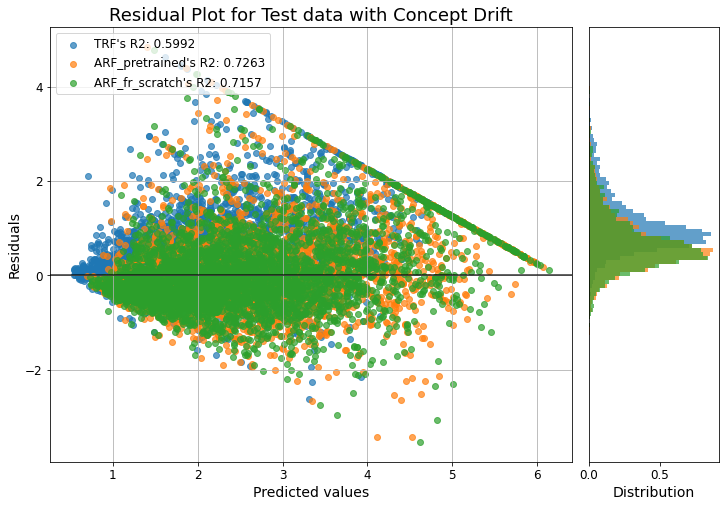

In [17]:
rg_pred_res['drift']['test']['model']['TRF'] = trf_rg
rg_pred_res['drift']['test']['model']['ARF_pretrained'] = trained_arf_rg
rg_pred_res['drift']['test']['model']['ARF_fr_scratch'] = trained_arf_rg_fr_scratch

params = {
    'pred_records': rg_pred_res['drift']['test'],
    'X': X_test_drifted,
    'y': y_test_drifted,
    'data_pp': data_pp,
    'binwidth': 0.1,
    'plot_title': 'Residual Plot for Test data with Concept Drift'
}

measure_performance(**params)

The difference of R2 in the offline and online set is calculated by substracting the training R2 score with the testing R2 score for each set.

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Diff R2 in Offline set</th>
        <th style="text-align:left;">Diff R2 in Online set</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.8394 - 0.7718 = 0.0676</td>
        <td style="text-align:center;">0.6493 - 0.5992 = 0.0501</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.8298 - 0.7724 = 0.0574</td>
        <td style="text-align:center;">0.7950 - 0.7263 = 0.0687</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.8169 - 0.7249 = 0.0920</td>
        <td style="text-align:center;">0.8042 - 0.7157 = 0.0885</td>
    </tr>
</table>

Unfortunately, the ARF still has the overfitting issue since the R2 difference in drifted data is between 6% to 9%. In business scenarios, further investigations are required for data scientists or researchers alike to perform thorough hyperparameter tunning to reduce the overfitting.

# Performance Overview

To visualize the performance of ARF and TRF over time, the models' running metrics are computed. The running metrics are calculated in four different stages, which are (*1*) offline train settings, (*2*) offline test settings, (*3*) online train settings, and (*4*) online test settings. By separating the calculation of running metrics into stages, the graph can showed more useful information by comparing performance across stages.

Besides TRF, the performance of two different ARFs are visualized. The first ARF is the model that incrementally trained with both offline train data and online train data. The second ARF is the model that get its weights from offline-trained TRF before incrementally trained with online train data. The purpose of comparison is to prove that second ARF performs better than first ARF during offline training. 

Below shows the detailed calculation of the running metrics:
1. Traditional random forest
    - For every 100 samples, get the predictions from the sample before updating the regression metrics containing the previous predictions.
    

2. Pre-trained ARF
    - **Offline train set**: Running metrics are not available since the weights are directly transferred. Thus, the calculation method is the same as traditional random forest.
    - **Online train set**: The running metrics are directly retrieved from the model training process. The running metrics are updated for every 100 training samples.
    - **Offline test and online test set**: The calculation method is the same as traditional random forest.


3. ARF that is trained from scratch
    - **Offline train and online train set**: The running metrics are directly retrieved from the model training process. The running metrics are updated for every 100 training samples.
    - **Offline test and online test set**: The calculation method is the same as traditional random forest.

Calculate the running metrics for the TRF model.

In [18]:
DATA_INTERVAL = 100

running_metrics_trf = {
    'mae': [],
    'mse': [],
    'r2': [],
}

# Stage 1
params = {
    'running_metrics': running_metrics_trf,
    'pred_records': rg_pred_res['normal']['train'],
    'model_type': 'TRF',
    'y_true': y_train,
    'data_interval': DATA_INTERVAL
}

get_running_metrics(**params)

# Stage 2
params['pred_records'] = rg_pred_res['normal']['test']
params['y_true'] = y_test

get_running_metrics(**params)

# Stage 3
params['pred_records'] = rg_pred_res['drift']['train']
params['y_true'] = y_train_drifted

get_running_metrics(**params)

# Stage 4
params['pred_records'] = rg_pred_res['drift']['test']
params['y_true'] = y_test_drifted

get_running_metrics(**params)

Calculating running metrics for TRF: 100%|███████████████████████████████| 42/42 [00:00<00:00, 412.90it/s]


Calculate the running metrics for the ARF model (that has undergone transfer learning).

In [19]:
running_metrics_arf = {
    'mae': [],
    'mse': [],
    'r2': [],
}

# Stage 1
params = {
    'running_metrics': running_metrics_arf,
    'pred_records': rg_pred_res['normal']['train'],
    'model_type': 'ARF_pretrained',
    'y_true': y_train,
    'data_interval': DATA_INTERVAL
}

get_running_metrics(**params)

# Stage 2
params['pred_records'] = rg_pred_res['normal']['test']
params['y_true'] = y_test

get_running_metrics(**params)

# Stage 3
for metric_name in running_metrics_arf:
    tmp = runninng_metrics_arf_train_drifted[metric_name]
    running_metrics_arf[metric_name] = running_metrics_arf[metric_name] + tmp

# Stage 4
params['pred_records'] = rg_pred_res['drift']['test']
params['y_true'] = y_test_drifted

get_running_metrics(**params)

Calculating running metrics for ARF_pretrained: 100%|████████████████████| 42/42 [00:00<00:00, 213.05it/s]


Calculate the running metrics for the ARF model that is trained from scratch.

In [20]:
running_metrics_new_arf = {
    'mae': [],
    'mse': [],
    'r2': [],
}

# Stage 1
# Update offline train metrics
for metric_name in running_metrics_new_arf:
    tmp = runninng_metrics_new_arf_train[metric_name]
    running_metrics_new_arf[metric_name] = running_metrics_new_arf[metric_name] + tmp

# Stage 2
params = {
    'running_metrics': running_metrics_new_arf,
    'model_type': 'ARF_fr_scratch',
    'data_interval': DATA_INTERVAL
}
params['pred_records'] = rg_pred_res['normal']['test']
params['y_true'] = y_test

# Update the offline test metrics before continuing to train on online data
get_running_metrics(**params)

# Stage 3
# Update online train metrics
for metric_name in running_metrics_new_arf:
    tmp = runninng_metrics_new_arf_train_drifted[metric_name]
    running_metrics_new_arf[metric_name] = running_metrics_new_arf[metric_name] + tmp

# Stage 4
params['pred_records'] = rg_pred_res['drift']['test']
params['y_true'] = y_test_drifted

# Update online test metrics
get_running_metrics(**params)

Calculating running metrics for ARF_fr_scratch: 100%|████████████████████| 42/42 [00:00<00:00, 294.23it/s]


## Visualization

Let:
- ARF model A: ARF model that has undergone transfer learning
- ARF model B: ARF model that is trained from scratch

Based on the graph **Running r2 of models versus training time**:

In the *offline setting*:
1. The performance of ARF model A is very close to TRF since the training weights is obtained from the same model.
2. The TRF is better than ARF model B in terms of the train performance and generalized performance. This is because:
    - TRF algorithm has the complete statistics for every attempt to split a leaf node, including the root node. This allows the TRF algorithm to choose the best split every single time. 
    - ARF algorithm do not have the full statistics to decide on a split, nor the foreknowledge on how big the train data is. Thus, the algorithm is designed to split on limited amount of samples using hyperparameters like grace period and Hoeffding bound. Upon splitting the root node, for each subsequent split attempt, the split decision is definitely suboptimal since the first splitting is also suboptimal.

In the *online setting*:
1. TRF model's performance rapidly drops when encoutering abruptly drifted data. Manual model retraining is required to replace with a new TRF model. However, the performance for both ARF models remain stable since model retraining is automatically taking place in the background. The algorithm will replace a base learner with the correspond background model if the base learner's performance degrades for some time.
2. The performance of ARF model B slowly recovers when train on drifted sample, up to a point where the performance of both ARF models are similar at the end. This shows that ARF model B requires more training samples to get the same performance as ARF model A. 

In short, the ARF model A generally has the best performance in both offline and online settings. Transfer learning from TRF to ARF combine the advantages of both TRF and ARF algorithms. The TRF algorithm provides batch learning that provides best split information to the ARF model A. While, the ARF algorithm provides incremental learning that is robust to drift.

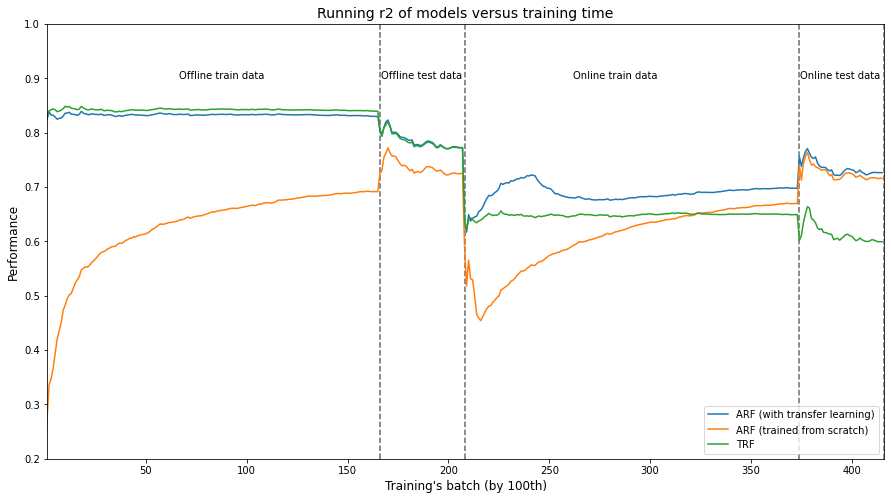

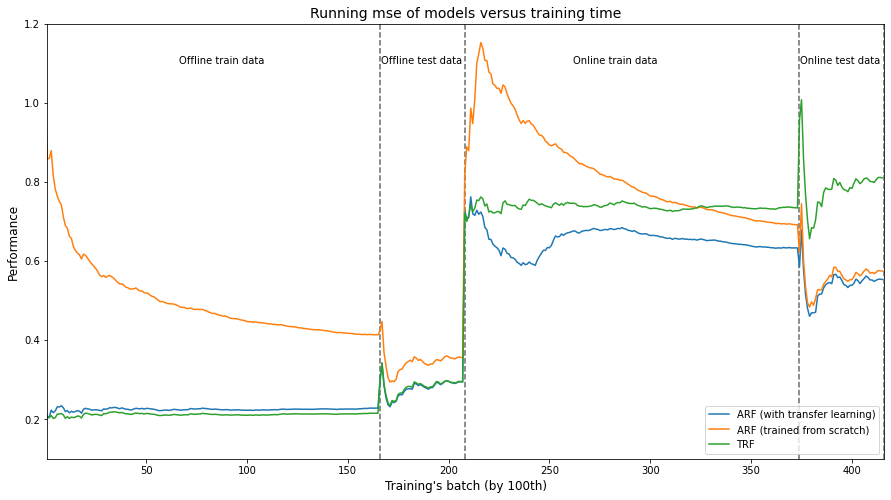

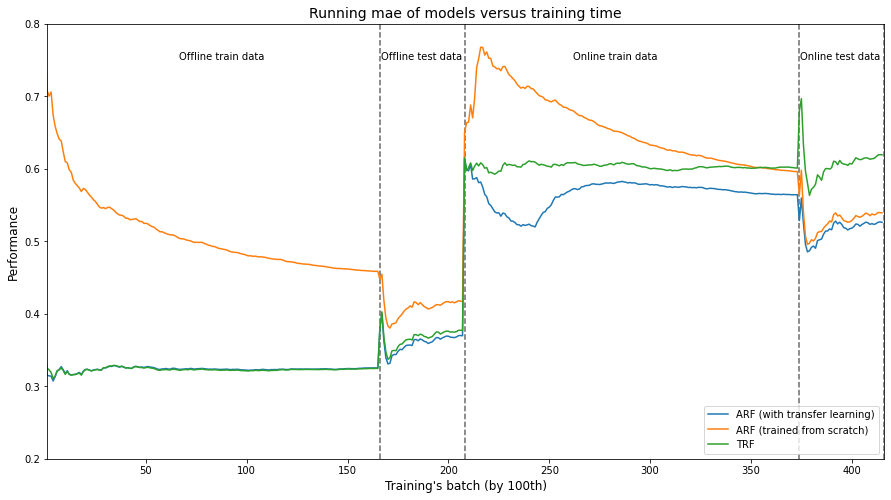

In [21]:
run_metrics_list = {
    'ARF (with transfer learning)': running_metrics_arf,
    'ARF (trained from scratch)': running_metrics_new_arf,
    'TRF': running_metrics_trf,
}

params = {
    'metrics_list': run_metrics_list, 
    'y_train_size': len(y_train),
    'y_test_size': len(y_test),
    'data_interval': DATA_INTERVAL,
    'text_x_positions': [0.4, 0.8, 0.7, 0.9]
}

text_y_positions = [0.9, 1.1, 0.75]
ylimits = [[0.2, 1.0], [0.1, 1.2], [0.2, 0.8]]

# Plot graphs by the type of metrics
for idx, metric_name in enumerate(['r2', 'mse', 'mae']):
    params['metric_type'] = metric_name
    params['text_y_position'] = text_y_positions[idx]
    params['ylimit'] = ylimits[idx]
    plot_performance_graph(**params)

# Conclusion

As a conclusion, the experiment verifies that:
1. The pre-trained ARF regressor's performance is at least good or better than ARF regressor that is trained from scratch in both offline settings and online settings.
2. The performance of the ARF regressor can be at least good or better than TRF regressor during initial training. This is done by "copying" the tree structure from TRF regressor to ARF regressor.
3. The performance of the ARF regressor is better than TRF regressor under the influence of data drift or concept drift.

As the drift occured, both models' performance degraded over time. It can be cleary observed that the rate of decrease in performance was more rapid in the TRF model as compared to ARF models. It is because for every base learner in the ARF ensemble, a new background tree is created and trained along with the current tree as soon as the warning drift detector detect any changes. Then, the drift detector will replace the current tree with the background tree if the change is detected again. This can be proven by comparing the number of nodes and height of each base learner before and after the online training.